In [4]:
from pyomo.environ import *
import matplotlib.pyplot as plt
import numpy as np
import random 
import operator
import pandas as pd
from skimage.transform import rescale, resize, downscale_local_mean

from matplotlib.image import imread

In [6]:
image = imread('Pyomo.png')
scale = 2
image_resized = resize(image, (image.shape[0] // scale, image.shape[1] //scale),
                       anti_aliasing=True)
imageToMatrice=image_resized

,index,x,y,s,Dark
count,3377.000000,3377.000000,3377.000000,3377.000000,3377.0
mean,3687.061889,45.668345,55.261771,0.883324,0.0
std,2068.114757,19.536245,21.909907,0.125102,0.0
min,98.000000,1.000000,8.000000,0.501343,0.0
25%,2007.000000,32.000000,38.000000,0.806151,0.0
50%,3508.000000,44.000000,57.000000,0.892696,0.0
75%,5299.000000,59.000000,73.000000,0.999861,0.0
max,8177.000000,93.000000,93.000000,1.000000,0.0


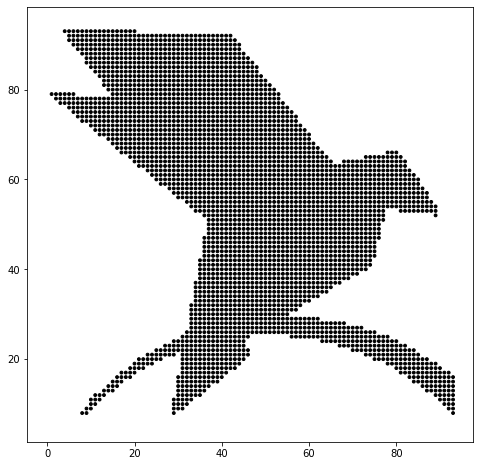

In [7]:
dic={}
c=0
for i in range(imageToMatrice.shape[0]):
    for j in range(imageToMatrice.shape[1]):
        dic[c,'x']=j
        dic[c,'y']=imageToMatrice.shape[1]-i
        dic[c,'s']=20*sum(imageToMatrice[i,j])/len(imageToMatrice[i,j])
        c+=1   
dic[c-1,'s']
dfN=pd.DataFrame()
dfN['x']=[dic[i,'x'] for i in range(c)]
dfN['y']=[dic[i,'y'] for i in range(c)]
dfN['s']=[80*(dic[i,'s']) for i in range(c)]

dfN['s']=(1*dfN['s']/dfN['s'].max() )
dfN['Dark']=1-round(dfN['s'],0)
dfN['marker']=['o' for i in range(c)]

fig= plt.figure(figsize=(8, 8))
R=20
x0=0.5*(dfN['x'].max()-dfN['x'].min())
y0=-1+0.5*(dfN['y'].max()-dfN['y'].min())
M = 300
theta =np.linspace(0,2*np.pi,M)

df=pd.DataFrame()
df['X']=x0+R*np.cos(theta)
df['Y']=3+y0+R*np.sin(theta)


plt.scatter(dfN['x'],dfN['y'],s=8*(1-dfN['Dark']), marker='o',c='k')
#plt.scatter(dfN['x'],dfN['y'],s=8*(1-dfN['Dark']), marker='.',c='b')

#plt.scatter(df['X'],df['Y'],s=8, marker='o',c='r')

dfN=dfN[dfN['Dark']==0 ]
dfN=dfN.reset_index()
dfN.describe() 

In [8]:
df = pd.DataFrame()
N=10

df['x'] = [10*random.random() for i in range(N)]
df['y'] = [10*random.random() for i in range(N)]
df['ti'] = [5*random.random() for i in range(N)]

df = dfN
N= len(df)

In [9]:
df

,index,x,y,s,Dark,marker
0,98,4,93,0.626367,0.0,o
1,99,5,93,0.834229,0.0,o
2,100,6,93,0.851230,0.0,o
3,101,7,93,0.841159,0.0,o
4,102,8,93,0.830582,0.0,o
...,...,...,...,...,...,...
3372,8083,93,9,0.846646,0.0,o
3373,8092,8,8,0.628095,0.0,o
3374,8093,9,8,0.576549,0.0,o
3375,8113,29,8,0.594815,0.0,o


In [10]:
df['x'].min()
df['y'].min()

df['x'] = [x+abs(df['x'].min()) for x in df['x'] ]
df['y'] = [x+abs(df['y'].min()) for x in df['y'] ]
df['ti'] = [5*random.random() for i in range(N)]

df

,index,x,y,s,Dark,marker,ti
0,98,5,101,0.626367,0.0,o,4.665668
1,99,6,101,0.834229,0.0,o,3.680468
2,100,7,101,0.851230,0.0,o,2.816235
3,101,8,101,0.841159,0.0,o,1.120722
4,102,9,101,0.830582,0.0,o,2.111285
...,...,...,...,...,...,...,...
3372,8083,94,17,0.846646,0.0,o,3.064317
3373,8092,9,16,0.628095,0.0,o,4.135429
3374,8093,10,16,0.576549,0.0,o,1.591232
3375,8113,30,16,0.594815,0.0,o,0.301165


In [11]:
x0, y0= 0,0 
model = AbstractModel()
model.i = RangeSet(N)
model.V0 = Var(model.i, bounds=(1,100), within=NonNegativeReals)
model.alpha = Var(model.i,bounds=(0,np.pi/2), within=Reals)
model.t = Var(bounds=(10,30), within=Reals)

def rule_x(model,i):
    return df.loc[i-1,'x']
def rule_y(model,i):
    return df.loc[i-1,'y']

model.x = Param(model.i, initialize=rule_x)
model.y = Param(model.i, initialize=rule_y)
def Rule_C1(model,i):
    return model.x[i]-x0== model.V0[i]*cos(model.alpha[i])*(model.t-df.loc[i-1,'ti']) 
model.C1=Constraint(model.i,rule=Rule_C1)

def Rule_C2(model,i):
    return model.y[i]-y0== -5*((model.t-df.loc[i-1,'ti'])**2) + model.V0[i]*sin(model.alpha[i])*(model.t-df.loc[i-1,'ti']) 
model.C2=Constraint(model.i,rule=Rule_C2)

def rule_OF(model):
    return model.t
model.obj1 = Objective(rule=rule_OF, sense=minimize)

In [12]:
opt = SolverFactory('ipopt')
instance = model.create_instance()  

In [13]:
results = opt.solve(instance) # solves and updates instance
from pyomo.opt import SolverStatus, TerminationCondition
if (results.solver.status == SolverStatus.ok) and (results.solver.termination_condition == TerminationCondition.optimal):
     print ("this is feasible and optimal")
elif results.solver.termination_condition == TerminationCondition.infeasible:
     print ("do something about it? or exit?")
else:
     print ('ERROR ' + str(results.solver))
print(value(instance.obj1) )


this is feasible and optimal
9.999999904595846
